# ПРОЕКТ ДЛЯ "ВИКИШОП" 📊

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Описание проекта: 📝

<div style="border:solid green 3px; padding: 20px">
    
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Цель проекта: 🎯

<div style="border:solid green 3px; padding: 20px">

Постройть модель, которая будет искать токсичные комментарии и отправлять их на модерацию.

Значение метрики качества F1 должно быть не меньше 0.75.

# План действий: 📅

<div style="border:solid green 3px; padding: 20px">
    
1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

## Подготовка

<div style="border:solid green 2px; padding: 5px">
    загружаем актуальную версию scikit-learn, а также библиотеку для работы с дисбалансом:

In [1]:
!pip install --upgrade -q pip

!pip install --upgrade -q scikit-learn

!pip install -U -q imbalanced-learn

<div style="border:solid green 2px; padding: 5px">
проверяем, что версия sklearn обновилась до последней:


In [2]:
import sklearn
print(sklearn.__version__)

1.4.1.post1


<div style="border:solid green 2px; padding: 5px">
    
выгружаем библиотеки, необходимые нам в работе, фиксируем RS:

In [3]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
nltk.download('averaged_perceptron_tagger')

RS = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<div style="border:solid green 2px; padding: 5px">
подгружаем готовый файл, сохраняем в переменную и выводим в виде таблиц и детализированных отчётов для изучения:

In [4]:
data_serv = '/datasets/toxic_comments.csv'
data_local = '/any_name/toxic_comments.csv'

if os.path.exists(data_serv):
    data = pd.read_csv(data_serv)
    print('Файл toxic_comments.csv найден на сервере и сохранён в переменную data')
elif os.path.exists(data_local):
    data = pd.read_csv(data_local)
    print('Файл toxic_comments.csv найден в локальной папке и сохранён в переменную data')
else:
    print('Файл toxic_comments.csv не найден')

Файл toxic_comments.csv найден на сервере и сохранён в переменную data


In [5]:
data.info()
print()
print(data.describe())
print()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

          Unnamed: 0          toxic
count  159292.000000  159292.000000
mean    79725.697242       0.101612
std     46028.837471       0.302139
min         0.000000       0.000000
25%     39872.750000       0.000000
50%     79721.500000       0.000000
75%    119573.250000       0.000000
max    159450.000000       1.000000



,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<div style="border:solid green 2px; padding: 5px">
    
Видим табличку с текстом и обозначением, является ли текст токсичным (цифра 1, если "да"), видим 159292 строк и отсутствие пропусков;
    
Посмотрим на соотношение количества токсичных комментариев в цифрах и на графике:

0    143106
1     16186
Name: toxic, dtype: int64


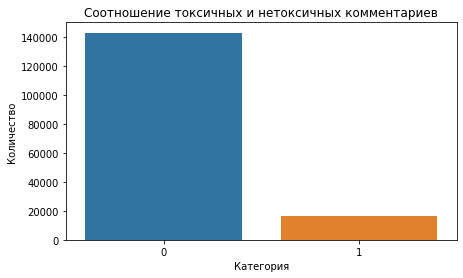

In [6]:
print(data['toxic'].value_counts())

plt.figure(figsize=(7, 4))
sns.countplot(x='toxic', data=data)
plt.title('Соотношение токсичных и нетоксичных комментариев')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show()

<div style="border:solid green 2px; padding: 5px"> 
    
Видим большую диспропорцию в соотношении токсичных комментариев от нетоксичных (1 к 9).
    
Для корректного и более качественного обучения модели потребуется уменьшить диспропорцию при помощи весов классов, сохраним вес классов в отдельную переменную:

In [7]:
class_weights = {0: 0.3, 1: 1}

<div style="border:solid green 2px; padding: 5px"> 
    
Проведём пробную лемматизацию текста и удостоверимся, что преобразование работает как надо:

In [8]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

stopwords = set(nltk.corpus.stopwords.words("english"))

word = 'feet'
print(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

sentence = "The striped bats are hanging on their feet for best"
print([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(sentence)])

foot
['The', 'strip', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best']


<div style="border:solid green 2px; padding: 5px"> 
    
Все нужные нам слова для проверки лемматизированы, лемматизация пройдена успешно
    
Теперь можно очистить, лемматизировать и векторизировать наш исконный текст, ввиду того что текстовый массив огромен, ограничимся 50000 строк текстов для ускорения обработки, после лемматизации поделим на выборки, чтоб уже выборки далее векторизировать:

In [11]:
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text

texts = data['text'].tolist()

num_texts_to_process = 50000

cleaned_texts = [clean_text(text) for text in texts[:num_texts_to_process]]
lemmatized_texts = []
for text in texts[:num_texts_to_process]:
    lemmatized_text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(text)]
    lemmatized_texts.append(lemmatized_text)

X = lemmatized_texts
y = data['toxic'][:num_texts_to_process]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RS)

X_train = [' '.join(text).lower() for text in X_train]
X_test = [' '.join(text).lower() for text in X_test]

tfidf = TfidfVectorizer(max_features=8500, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
print("Проверка преобразования:", lemmatized_texts[0])

Проверка преобразования: ['Explanation', 'Why', 'the', 'edits', 'make', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'be', 'revert', '?', 'They', 'be', "n't", 'vandalism', ',', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'vote', 'at', 'New', 'York', 'Dolls', 'FAC', '.', 'And', 'please', 'do', "n't", 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'m", 'retire', 'now.89.205.38.27']


<div style="border:solid green 2px; padding: 5px"> 
    
Преобразование очищено и лемматизировано, можно приступить к обучению моделей

<div style="border:solid green 3px; padding: 15px"> 

# Промежуточный вывод:
    
1. обновили scikit-learn
2. подгрузили необходимые библиотеки
3. изучили файл toxic_comments.csv, построили столбчатую диаграмму, проанализировали диспропорцию
4. перебором определили оптимальные веса классов для лучшего прогнозирования моделей
5. провели очистку, лемматизацию и векторизацию текста


## Обучение

<div style="border:solid green 2px; padding: 5px"> 
    
При помощи GridSearchCV определим наилучшие гиперпараметры и обучим модель LogisticRegression:

In [20]:
%%time

lr = LogisticRegression(random_state=RS, class_weight={0: 0.3, 1: 1})

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr)
])

param_grid = {
    'lr__C': [0.001, 0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear']
}

grid_search_lr = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search_lr.fit(X_train, y_train)

best_params = grid_search_lr.best_params_

print('Наилучшие параметры модели LogisticRegression:', best_params)
print(f'Качество модели по кросс-валидации: {grid_search_lr.best_score_}')

# Наилучшие параметры модели LogisticRegression: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Наилучшие параметры модели LogisticRegression: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Качество модели по кросс-валидации: 0.7567089127505119
CPU times: user 1min 32s, sys: 591 ms, total: 1min 32s
Wall time: 1min 32s


<div style="border:solid green 2px; padding: 5px"> 
    
При помощи GridSearchCV определим наилучшие гиперпараметры и обучим модель RandomForestClassifier:

In [21]:
%%time

rf = RandomForestClassifier(random_state=RS)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)

best_params = grid_search_rf.best_params_

print('Наилучшие параметры модели RandomForestClassifier:', best_params)
print(f'Качество модели по кросс-валидации: {grid_search_rf.best_score_}')

#Наилучшие параметры модели RandomForestClassifier: 
#{'rf__max_depth': 20, 'rf__min_samples_leaf': 1, #'rf__min_samples_split': 2, 'rf__n_estimators': 100}

Наилучшие параметры модели RandomForestClassifier: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Качество модели по кросс-валидации: 0.12123554331322257
CPU times: user 6min 1s, sys: 417 ms, total: 6min 2s
Wall time: 6min 2s


<div style="border:solid green 2px; padding: 5px"> 
    
При помощи GridSearchCV определим наилучшие гиперпараметры и обучим модель CatBoostClassifier:

In [22]:
%%time

cb = CatBoostClassifier(loss_function="Logloss", verbose=False)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('cb', cb)
])

param_grid = {
    'cb__learning_rate': [0.01, 1],
    'cb__iterations': [10, 50]
}

grid_search_cb = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search_cb.fit(X_train, y_train)

best_params = grid_search_cb.best_params_

print('Наилучшие параметры модели CatBoostClassifier:', best_params)
print(f'Качество модели по кросс-валидации: {grid_search_cb.best_score_}')

#Лучшие параметры модели CatBoostClassifier: {'iterations': 50, 'learning_rate': 1}

Наилучшие параметры модели CatBoostClassifier: {'cb__iterations': 50, 'cb__learning_rate': 1}
Качество модели по кросс-валидации: 0.722062167766912
CPU times: user 6min 11s, sys: 5.14 s, total: 6min 16s
Wall time: 6min 27s


<div style="border:solid green 2px; padding: 5px"> 
    
При помощи GridSearchCV определим наилучшие гиперпараметры и обучим модель LGBMClassifier:

In [24]:
%%time

lg = lgb.LGBMClassifier()

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('lg', lg)
])

param_grid = {
    'lg__objective': ['binary'],
    'lg__metric': ['binary_logloss'],
    'lg__boosting_type': ['gbdt'],
    'lg__learning_rate': [0.1, 1],
    'lg__num_leaves': [31, 50],
    'lg__max_depth': [10, 20]
}

grid_search_lg = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search_lg.fit(X_train, y_train)

best_params = grid_search_lg.best_params_

print('Наилучшие параметры модели LGBMClassifier:', best_params)
print(f'Качество модели по кросс-валидации: {grid_search_lg.best_score_}')

# Наилучшие параметры модели LGBMClassifier: {'lg__boosting_type': 'gbdt', 'lg__learning_rate': 0.1, 
#'lg__max_depth': 20, 'lg__metric': 'binary_logloss', 'lg__num_leaves': 31, 'lg__objective': 'binary'}

Наилучшие параметры модели LGBMClassifier: {'lg__boosting_type': 'gbdt', 'lg__learning_rate': 0.1, 'lg__max_depth': 20, 'lg__metric': 'binary_logloss', 'lg__num_leaves': 31, 'lg__objective': 'binary'}
Качество модели по кросс-валидации: 0.71664059145468
CPU times: user 26min 47s, sys: 2.11 s, total: 26min 49s
Wall time: 26min 51s


<div style="border:solid green 3px; padding: 15px"> 

# Промежуточный вывод:
    
1. выделили признаки, сохранили в переменные
2. разбили данные на выборки, провели векторизацию тренировочных данных
3. обучили 4 различные модели на наилучших гиперпараметрах

## Выводы

<div style="border:solid green 2px; padding: 5px"> 
    
Исходя из метрик оценки при кросс-валидации, наиболее удачная модель оказалась LogisticRegression с результатом 0.77, проверим данную модель на тестовых данных:

In [27]:
pred_lr = grid_search_lr.predict(X_test)
f1_lr = f1_score(y_test, pred_lr)
print('F1 лучшей модели LogisticRegression на тестовой выборке - {:.2f}'.format(f1_lr))

F1 лучшей модели LogisticRegression на тестовой выборке - 0.78


<div style="border:solid green 2px; padding: 5px"> 
    
Лучшей моделью по значению метрики F1 является LogisticRegression с показателем 0.78, что подходит условию задачи (> 0.75), также эта модель показывает наиболее быструю скорость обучения на данных, а значит, данную модель можно использовать в сервисе в дальнейшем.

<div style="border:solid green 4px; padding: 15px"> 

# Итоговый вывод:
    
1. Провели подготовку данных:
    
    а) Обновили scikit-learn, подгрузили необходимые библиотеки;
    
    б) Изучили файл toxic_comments.csv;
    
    в) Провели визуализацию, исследовали диспропорцию, определили оптимальный вес классов;
    
2. Провели обучение моделей:
    
    а) Выделили признаки, разбили данные на выборки, векторизировали тренировочные данные;
    
    б) Обучили 4 разные модели;
    
    в) Отобрали наилучшую модель по лучшему показателю F1 для дальнейшего прогнозирования;
    
ЗАКЛЮЧЕНИЕ: Для наилучшего предсказания точности определения токсичных текстов с наиболее быстрой обучаемостью рекомендуется использовать модель LogisticRegression.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны